# Feature visualization


<br>
<img src='https://i.imgur.com/lMR9UAU.png'>
<br>

**Tarea:** Adapta el código anterior para conseguir este efecto de Vis. de Características para el ***Feature Map #0*** de la capa ***Mixed5***. Para ello:

- Crea una imagen de ruido aleatorio que usaremos como imagen de entrada, de tamaño 256x256x3, con valores que varíen del 0-255.

- Estudia y adapta el funcionamiento del código anterior para introducir la modificación necesaria para lograr este efecto. 

In [ ]:
# Importamos las librerías necesarias
import tensorflow as tf
import numpy as np
import matplotlib as mpl

import IPython.display as display
import PIL.Image

In [ ]:
# Método para deshacer el preprocesamiento.
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)
  
# Visualizar una imagen.
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

[[[ 26 145 187]
  [201 108 246]
  [239 153   4]
  ...
  [225 243 160]
  [225  66  83]
  [209  24 210]]

 [[ 98 224  98]
  [121  98 240]
  [120 102 201]
  ...
  [ 91  59 168]
  [185 194 197]
  [196 171   6]]

 [[150 201 220]
  [ 70 254 221]
  [164  20 188]
  ...
  [180  43 110]
  [144  93 182]
  [ 17   1  50]]

 ...

 [[ 36  27  63]
  [ 79  22  23]
  [173 106 218]
  ...
  [206 135  93]
  [ 58  55 245]
  [ 73 245  24]]

 [[217 112  23]
  [225 174  41]
  [186 221   9]
  ...
  [181 173  13]
  [ 80 148 207]
  [ 21   5 136]]

 [[230  84 100]
  [  7  60 242]
  [148 168 189]
  ...
  [ 95  44 219]
  [  1 155 122]
  [206  47  25]]]


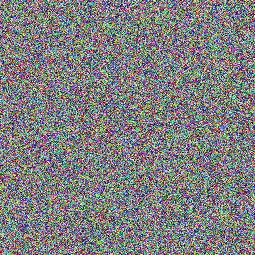

In [ ]:
#Creamos imagen con ruido aleatorio

randnums= np.random.randint(0,255,255*255*3)

noisyimg = randnums.reshape(255,255,3)
print(noisyimg)
noisyimg = noisyimg.astype(np.uint8)
show(noisyimg)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Ahora, cargamos un modelo pre-entrenado como InceptionV3 o VGG.
base_model = InceptionV3(include_top=False, weights='imagenet')

# Podemos visualizar la arquitectura de la red cargada.
for i, layer in enumerate(base_model.layers):
  print('Layer ' + str(i) + ':', layer.name)

87924736/87910968 [==============================] - 2s 0us/step
Layer 0: input_1
Layer 1: conv2d
Layer 2: batch_normalization
Layer 3: activation
Layer 4: conv2d_1
Layer 5: batch_normalization_1
Layer 6: activation_1
Layer 7: conv2d_2
Layer 8: batch_normalization_2
Layer 9: activation_2
Layer 10: max_pooling2d
Layer 11: conv2d_3
Layer 12: batch_normalization_3
Layer 13: activation_3
Layer 14: conv2d_4
Layer 15: batch_normalization_4
Layer 16: activation_4
Layer 17: max_pooling2d_1
Layer 18: conv2d_8
Layer 19: batch_normalization_8
Layer 20: activation_8
Layer 21: conv2d_6
Layer 22: conv2d_9
Layer 23: batch_normalization_6
Layer 24: batch_normalization_9
Layer 25: activation_6
Layer 26: activation_9
Layer 27: average_pooling2d
Layer 28: conv2d_5
Layer 29: conv2d_7
Layer 30: conv2d_10
Layer 31: conv2d_11
Layer 32: batch_normalization_5
Layer 33: batch_normalization_7
Layer 34: batch_normalization_10
Layer 35: batch_normalization_11
Layer 36: activation_5
Layer 37: activation_7
Layer 38:

In [ ]:
# Elegimos de qué capas queremos obtener las activaciones a maximizar.
layers = [base_model.get_layer(name).output for name in ['mixed5']]

# Creamos un modelo que tendrá puntos de output en las capas elegidas.
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
# Este método pasará la imagen por la red neuronal pre-entrenada
# y sacará de ella los mapas de activaciones al pasar por el filtro
# o los filtros correspondientes. Ese será el Loss a optimizar.

def calc_loss(img, model):
  
  # Añade la dimensión de batch a la imagen. 
  # [256, 256, 3] -> [1, 256, 256, 3]
  img_batch = tf.expand_dims(img, axis=0)

  # Da como input la imagen al modelo
  # y obtiene los feature maps.
  layer_activations = model(img_batch)

  # Para todos los feature maps de cada capa,
  # calcularemos cuál es la media de sus activaciones
  # y las sumaremos todas para calcular el valor
  # a optimizar, que guardaremos en loss.
  losses = []

  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  for act in layer_activations:
    # Seleccionamos todos los feature maps.
    loss = tf.math.reduce_mean(act[:,:,:,0])
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
import scipy

# Creamos el un módulo de Tensorflow para implementar
# la lógica de Deep Dream.
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  def __call__(self, img, steps, step_size):
      
      print("Calculando steps...")

      loss = tf.constant(0.0)
      
      # Creamos el 'bucle de entrenamiento'
      for n in tf.range(steps):

        # Y registramos las operaciones necesarias. En este
        # caso, son las operaciones que conectan a nuestra
        # imagen de entrada, con el 'loss' que queremos
        # optimizar: en este caso la activación de los f.maps.
        with tf.GradientTape() as tape:
          
          # Explicitamente tenemos que decirle a Tensorflow que
          # los píxeles de nuestra imagen son parámetros a vigilar.
          tape.watch(img)
          # Usamos el método para calcular la activación de las capas
          # seleccionadas.
          loss = calc_loss(img, self.model)

        # Calculamos el gradiente entre los píxeles y las activaciones.
        gradients = tape.gradient(loss, img)

        # Normalizamos los valores del gradiente.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.

        # ----- Esto lo comentaremos posteriormente ------ #        
        # img = scipy.ndimage.rotate(img, 0.2 * (np.random.rand() - 0.5), reshape=False)
        # img = scipy.ndimage.shift(img, [0.1 * (np.random.rand() - 0.5),
        #                                 0.1 * (np.random.rand() - 0.5), 0])
        # img = tf.convert_to_tensor(img)


        # Y realizamos el ASCENSO del gradiente, es decir, sumamos el vector gradiente.
        img = img + gradients * step_size
        # Controlamos que los píxeles de las imágenes sigan en el rango [-1, 1]
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

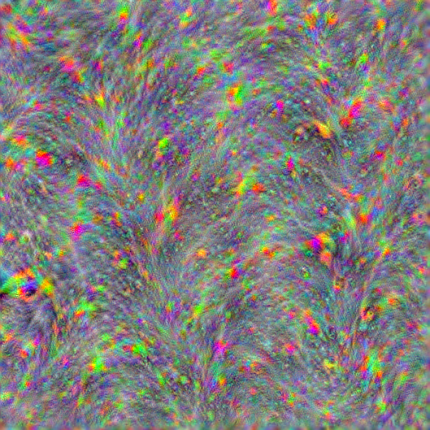

Ciclo 2, loss 11.47426986694336


In [ ]:
OCTAVE_SCALE = 1.30

deepdream = DeepDream(dream_model)

cycles    = 3
run_steps = 100
step_size = 0.001

img = noisyimg

# Preprocesamos a la imagen con el preprocesamiento necesario.
img = tf.convert_to_tensor(preprocess_input(img))

# Guardamos la forma original de la imagen.
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-3, 3):

  # Calculamos la nueva forma de la imagen.
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
  # Y le cambiamos el tamaño.
  img = tf.image.resize(img, new_shape)

  # Para cada ciclo...
  for cycle in range(cycles):
    
    # Llamamos al modelo de Deep Dream y ejecutamos unos cuantos steps.
    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    # Visualiazmos el resultado.
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Ciclo {}, loss {}".format(cycle, loss))